Coherence score for spam topic model: 0.6304134957309352


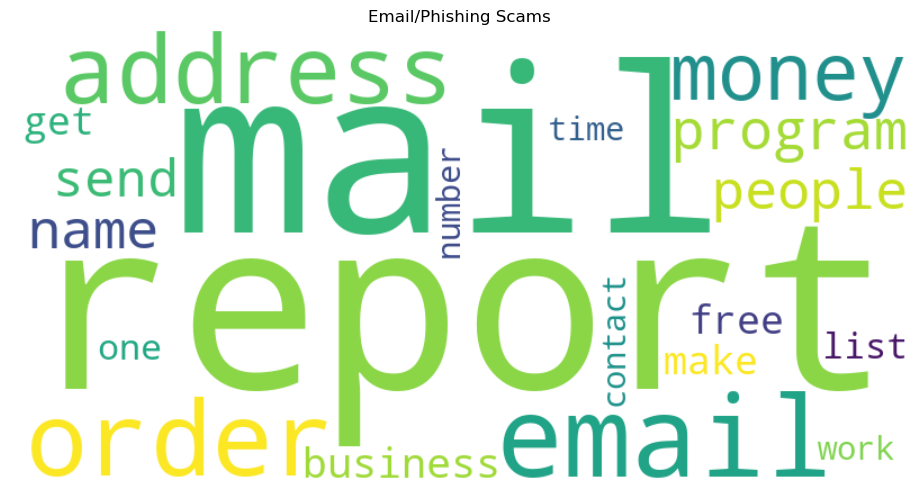

The coherence score of your text with the topic chosen is 0.4521


In [22]:
import os
import re
import ast
import pandas as pd
import numpy as np
import tqdm
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

from gensim.models import Phrases
from gensim import corpora
from gensim.models import CoherenceModel

from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from gensim.models.nmf import Nmf


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def preprocess_text(text):

    # Define custom stopwords
    custom_stopwords = set(stopwords.words('english'))
    # custom_stopwords = set(stopwords.words('english')) | {'enron'}

    # Initialize WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()

    if not isinstance(text, str):
        return ""
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize into words, remove stopwords, lemmatize, and filter out short words
    tokens = word_tokenize(text.lower())
    filtered_words = [lemmatizer.lemmatize(word) for word in tokens if word not in custom_stopwords and len(word) > 1]
    return filtered_words

def get_dict(path): 
    # Read the CSV file
    df = pd.read_csv(path)

    # Preprocess text data
    df['tokens'] = df['text'].apply(preprocess_text)

    # Separate spam and ham text - Unigram
    uni_spam_df = df[df['label'] == 'spam']
    uni_ham_df = df[df['label'] == 'ham']

    # Create dictionary and corpus for spam text - Unigram
    uni_spam_dictionary = corpora.Dictionary(uni_spam_df['tokens'])
    uni_spam_corpus = [uni_spam_dictionary.doc2bow(text) for text in uni_spam_df['tokens']]

    # Create dictionary and corpus for ham text - Unigram
    uni_ham_dictionary = corpora.Dictionary(uni_ham_df['tokens'])
    uni_ham_corpus = [uni_ham_dictionary.doc2bow(text) for text in uni_ham_df['tokens']]

    # Text Col
    uni_col = "tokens"

    return uni_spam_df, uni_ham_df, uni_spam_corpus, uni_ham_corpus, uni_spam_dictionary, uni_ham_dictionary

# Build NMF model for spam text
def spamNMFModel(spamDict, hamDict, spamCorp, hamCorp, spamIdDict, hamIdDict, textCol, numTopics):
    
    spam_nmf_model = Nmf(
        corpus=spamCorp, 
        num_topics=numTopics, 
        id2word=spamIdDict,
        chunksize=100,
        passes=2,
        random_state=42
    )

    # Build LDA model for ham text
    ham_nmf_model = Nmf(corpus=hamCorp, num_topics=numTopics, id2word=hamIdDict)
        
    # Calculate coherence score for spam topics
    spam_coherence_model = CoherenceModel(model=spam_nmf_model, texts=spamDict[textCol], dictionary=spamIdDict, coherence='c_v')
    spam_coherence_score = spam_coherence_model.get_coherence()
#     print("Coherence score for spam topics:", spam_coherence_score)

    # Calculate coherence score for ham topics
    ham_coherence_model = CoherenceModel(model=ham_nmf_model, texts=hamDict[textCol], dictionary=hamIdDict, coherence='c_v')
    ham_coherence_score = ham_coherence_model.get_coherence()
#     print("Coherence score for ham topics:", ham_coherence_score)
    
    return spam_nmf_model, ham_nmf_model, spam_coherence_score, ham_coherence_score

# def get_gensim_nmf_model(uni_spam_df, uni_ham_df, uni_spam_corpus, uni_ham_corpus, uni_spam_dictionary, uni_ham_dictionary): 

#     # Gensim NMF Model - Uni - Spam
#     uni_spam_nmf_num_topics1 = 7
#     uni_spam_nmf_model1, uni_ham_nmf_model1, uni_spam_nmf_coher1, uni_ham_nmf_coher1 = spamNMFModel(uni_spam_df, uni_ham_df, uni_spam_corpus, uni_ham_corpus, uni_spam_dictionary, uni_ham_dictionary, "tokens", uni_spam_nmf_num_topics1)

#     new_topics=[]

#     for topic_id, topic in uni_spam_nmf_model1.print_topics(num_topics=uni_spam_nmf_num_topics1, num_words=20):
#         # print(f'Topic {topic_id}: {topic}')
#         indiv_topic_dict = {}
#         indiv_topic = topic.split(" + ")
#         for ind in indiv_topic:
#             sep = ind.split("*")
#             word = sep[1][1:-1]
#             val = float(sep[0])
#             indiv_topic_dict[word] = val
#         new_topics.append(indiv_topic_dict)

#     print("Coherence score for spam topic model:", uni_spam_nmf_coher1)
#     return uni_spam_nmf_model1, new_topics



def get_topic(path, input_text): 
    inputText = preprocess_text(input_text)
    uni_spam_df, uni_ham_df, uni_spam_corpus, uni_ham_corpus, uni_spam_dictionary, uni_ham_dictionary = get_dict(path) 
    inputTextDf = pd.DataFrame({"text": inputText})

    min_topics = 2
    max_topics = 11
    step_size = 1
    topics_range = range(min_topics, max_topics, step_size)

    topic_labels_spam = [
        "HTML/Website Spams",
        "Email/Phishing Scams",
        "Investment/Financial Scams",
        "Foreign Language Spam", # was spanish spam
        "Housing/Urgent Account Scams",
        "Travel/Promotion Advertising Scams",
        "Company Information Scams",
    ]

    # Gensim NMF Model - Uni - Spam
    uni_spam_nmf_num_topics1 = 7
    uni_spam_nmf_model1, uni_ham_nmf_model1, uni_spam_nmf_coher1, uni_ham_nmf_coher1 = spamNMFModel(uni_spam_df, uni_ham_df, uni_spam_corpus, uni_ham_corpus, uni_spam_dictionary, uni_ham_dictionary, "tokens", uni_spam_nmf_num_topics1)

    new_topics=[]

    for topic_id, topic in uni_spam_nmf_model1.print_topics(num_topics=uni_spam_nmf_num_topics1, num_words=20):
        # print(f'Topic {topic_id}: {topic}')
        indiv_topic_dict = {}
        indiv_topic = topic.split(" + ")
        for ind in indiv_topic:
            sep = ind.split("*")
            word = sep[1][1:-1]
            val = float(sep[0])
            indiv_topic_dict[word] = val
        new_topics.append(indiv_topic_dict)

    print("Coherence score for spam topic model:", uni_spam_nmf_coher1)

    new_text_corpus =  uni_spam_dictionary.doc2bow(inputTextDf['text'][0].split())
    # predicted topic distribution
    pred_topic_distri = uni_spam_nmf_model1[new_text_corpus]

    max_coher = max(pred_topic_distri, key=lambda x: x[1])
    topic_chosen_id = max_coher[0]
    topic_coher_score = max_coher[1]
    topic_chosen_dict = new_topics[topic_chosen_id]
    topic_label = topic_labels_spam[topic_chosen_id]

    return topic_chosen_dict, topic_label, topic_coher_score



# Main function
# the below functions should be called in the main function
# rmb to add generate_wordcloud_per_topic to the main function 

def generate_wordcloud_per_topic(topic, topic_label):
    # Create a figure with multiple subplots, one for each topic
    fig, axes = plt.subplots(figsize=(10, 5))

    # Generate a word cloud for the current topic
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(topic)

    # Plot the word cloud for the current topic
    axes.imshow(wordcloud, interpolation='bilinear')
    axes.set_title(topic_label)
    axes.axis('off')
    
    plt.tight_layout()
    plt.show()

# Define path to the CSV file
path = '../../data/train_data.csv'
inputText = "the most popular software available at the rock - bottom prices . software : windows xp suites , adobe , macromedia , corel , symantec , mcafee , operating systems and utilities . download copy of your software today ! microsoft windows xp professional our price : 80 retail price : $ 200 you save : $ 120 microsoft office 2003 professional our price : 120 retail price : $ 300 you save : $ 180 adobe photoshop 8 . 0 / cs our price : $ 100 retail price : $ 500 you save : $ 400 macromedia studio mx 2004 our price : $ 180 retail price : $ 980 you save : $ 800 adobe acrobat 6 . 0 professional our price : $ 150 retail price : $ 300 you save : $ 150 norton internet security pro 2004 our price : $ 50 retail price : $ 90 you save : $ 40 mcafee personal firewall plus 2004 our price : $ 20 retail price : $ 40 you save : $ 20 corel draw graphics suite 11 our price : $ 80 retail price : $ 200 you save : $ 120 symantec pcanywhere 11 . 0 our price : $ 60 retail price : $ 210 you save : $ 150 adobe illustrator cs / full new version our price : $ 100 retail price : $ 499 you save : $ 399 ahead nero 6 . 3 powerpack our price : $ 60 retail price : $ 100 you save : $ 40 quicken 2004 premier home & biz our price : $ 40 retail price : $ 90 you save : $ 50 winfax pro 10 . 03 our price : $ 40 retail price : $ 100 you save : $ 60 | rie | mio | vie | | yio | u | e | - | mia | iil |"

topic_chosen_dict, topic_label, topic_coher_score = get_topic(path, inputText)

generate_wordcloud_per_topic(topic_chosen_dict, topic_label)
print(f"The coherence score of your text with the topic chosen is {round(topic_coher_score,4)}")




In [20]:
import os
import re
import ast
import pandas as pd
import numpy as np
import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from gensim.models import Phrases
from gensim import corpora
from gensim.models import CoherenceModel

from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from gensim.models.nmf import Nmf


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data here

In [8]:
# Read the CSV file
df = pd.read_csv('../../data/train_data.csv')

# Define custom stopwords
custom_stopwords = set(stopwords.words('english'))
# custom_stopwords = set(stopwords.words('english')) | {'enron'}

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize into words, remove stopwords, lemmatize, and filter out short words
    tokens = word_tokenize(text.lower())
    filtered_words = [lemmatizer.lemmatize(word) for word in tokens if word not in custom_stopwords and len(word) > 1]
    return filtered_words

# Preprocess text data
df['tokens'] = df['text'].apply(preprocess_text)

# Separate spam and ham text - Unigram
uni_spam_df = df[df['label'] == 'spam']
uni_ham_df = df[df['label'] == 'ham']

# Create dictionary and corpus for spam text - Unigram
uni_spam_dictionary = corpora.Dictionary(uni_spam_df['tokens'])
uni_spam_corpus = [uni_spam_dictionary.doc2bow(text) for text in uni_spam_df['tokens']]

# Create dictionary and corpus for ham text - Unigram
uni_ham_dictionary = corpora.Dictionary(uni_ham_df['tokens'])
uni_ham_corpus = [uni_ham_dictionary.doc2bow(text) for text in uni_ham_df['tokens']]

# Text Col
uni_col = "tokens"

In [9]:
def generate_wordcloud_per_topic(topic, topic_label):
    # Create a figure with multiple subplots, one for each topic
    fig, axes = plt.subplots(figsize=(10, 5))

    # Generate a word cloud for the current topic
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(topic)

    # Plot the word cloud for the current topic
    axes.imshow(wordcloud, interpolation='bilinear')
    axes.set_title(topic_label)
    axes.axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

topic_labels_spam = [
    "HTML/Website Spams",
    "Email/Phishing Scams",
    "Investment/Financial Scams",
    "Foreign Language Spam", # was spanish spam
    "Housing/Urgent Account Scams",
    "Travel/Promotion Advertising Scams",
    "Company Information Scams",
]

# topic_labels_ham = [
#     "Marketing/Sales",
#     "Order Processing/Customer Service",
#     "Design/Typography",
#     "Travel/Booking",
#     "Security/Notifications",
#     "Financial/Investment Reports",
#     "Energy/Investment Projects",
#     "Foreign Language Emails",
#     "Technology/Security Reports",
#     "Contact Information/Claims"
# ]


## Model here

In [11]:
# Build NMF model for spam text
def spamNMFModel(spamDict, hamDict, spamCorp, hamCorp, spamIdDict, hamIdDict, textCol, numTopics):
    
    spam_nmf_model = Nmf(
        corpus=spamCorp, 
        num_topics=numTopics, 
        id2word=spamIdDict,
        chunksize=100,
        passes=2,
        random_state=42
    )

    # Build LDA model for ham text
    ham_nmf_model = Nmf(corpus=hamCorp, num_topics=numTopics, id2word=hamIdDict)
        
    # Calculate coherence score for spam topics
    spam_coherence_model = CoherenceModel(model=spam_nmf_model, texts=spamDict[textCol], dictionary=spamIdDict, coherence='c_v')
    spam_coherence_score = spam_coherence_model.get_coherence()
#     print("Coherence score for spam topics:", spam_coherence_score)

    # Calculate coherence score for ham topics
    ham_coherence_model = CoherenceModel(model=ham_nmf_model, texts=hamDict[textCol], dictionary=hamIdDict, coherence='c_v')
    ham_coherence_score = ham_coherence_model.get_coherence()
#     print("Coherence score for ham topics:", ham_coherence_score)
    
    return spam_nmf_model, ham_nmf_model, spam_coherence_score, ham_coherence_score


In [12]:
# Gensim NMF Model - Uni - Spam
uni_spam_nmf_num_topics1 = 7
uni_spam_nmf_model1, uni_ham_nmf_model1, uni_spam_nmf_coher1, uni_ham_nmf_coher1 = spamNMFModel(uni_spam_df, uni_ham_df, uni_spam_corpus, uni_ham_corpus, uni_spam_dictionary, uni_ham_dictionary, "tokens", uni_spam_nmf_num_topics1)

new_topics=[]

for topic_id, topic in uni_spam_nmf_model1.print_topics(num_topics=uni_spam_nmf_num_topics1, num_words=20):
    # print(f'Topic {topic_id}: {topic}')
    indiv_topic_dict = {}
    indiv_topic = topic.split(" + ")
    for ind in indiv_topic:
        sep = ind.split("*")
        word = sep[1][1:-1]
        val = float(sep[0])
        indiv_topic_dict[word] = val
    new_topics.append(indiv_topic_dict)

print("Coherence score for spam topic model:", uni_spam_nmf_coher1)

Coherence score for spam topic model: 0.6304134957309352


## Input here

In [13]:
inputText = preprocess_text("the most popular software available at the rock - bottom prices . software : windows xp suites , adobe , macromedia , corel , symantec , mcafee , operating systems and utilities . download copy of your software today ! microsoft windows xp professional our price : 80 retail price : $ 200 you save : $ 120 microsoft office 2003 professional our price : 120 retail price : $ 300 you save : $ 180 adobe photoshop 8 . 0 / cs our price : $ 100 retail price : $ 500 you save : $ 400 macromedia studio mx 2004 our price : $ 180 retail price : $ 980 you save : $ 800 adobe acrobat 6 . 0 professional our price : $ 150 retail price : $ 300 you save : $ 150 norton internet security pro 2004 our price : $ 50 retail price : $ 90 you save : $ 40 mcafee personal firewall plus 2004 our price : $ 20 retail price : $ 40 you save : $ 20 corel draw graphics suite 11 our price : $ 80 retail price : $ 200 you save : $ 120 symantec pcanywhere 11 . 0 our price : $ 60 retail price : $ 210 you save : $ 150 adobe illustrator cs / full new version our price : $ 100 retail price : $ 499 you save : $ 399 ahead nero 6 . 3 powerpack our price : $ 60 retail price : $ 100 you save : $ 40 quicken 2004 premier home & biz our price : $ 40 retail price : $ 90 you save : $ 50 winfax pro 10 . 03 our price : $ 40 retail price : $ 100 you save : $ 60 | rie | mio | vie | | yio | u | e | - | mia | iil |")

In [14]:
inputTextDf = pd.DataFrame({"text": inputText})
new_text_corpus =  uni_spam_dictionary.doc2bow(inputTextDf['text'][0].split())

In [15]:
# predicted topic distribution
pred_topic_distri = uni_spam_nmf_model1[new_text_corpus]
pred_topic_distri

[(0, 0.0907753804007413),
 (1, 0.4521459671382798),
 (2, 0.07520652116755226),
 (3, 0.17359493646184587),
 (5, 0.20827719483158072)]

In [16]:
max_coher = max(pred_topic_distri, key=lambda x: x[1])
topic_chosen_id = max_coher[0]
topic_coher_score = max_coher[1]
topic_chosen_dict = new_topics[topic_chosen_id]
topic_label = topic_labels_spam[topic_chosen_id]

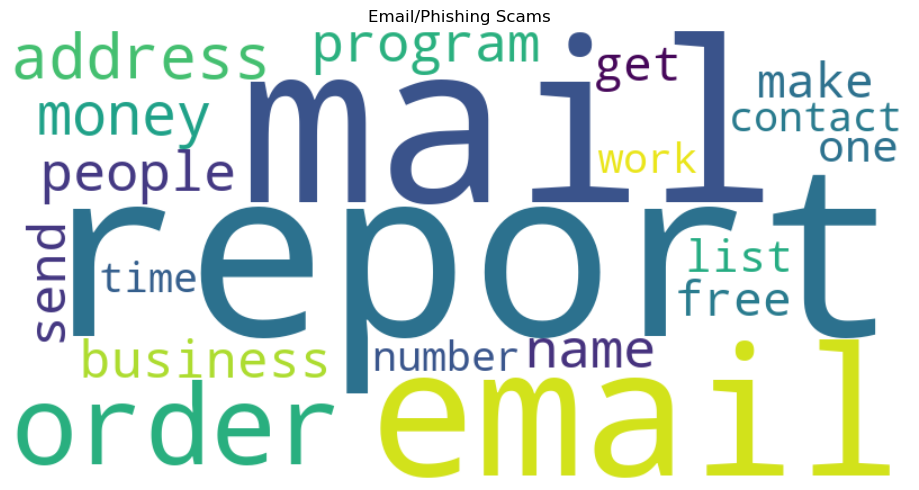

The coherence score of your text with the topic chosen is 0.4521


In [17]:
generate_wordcloud_per_topic(topic_chosen_dict, topic_label)
print(f"The coherence score of your text with the topic chosen is {round(topic_coher_score,4)}")

In [19]:
import gensim
gensim.__version__

'4.3.2'